# Online system identification in Duffing oscillator by free energy minimisation

This project considers a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), a driven damped harmonic oscillator with a cubic nonlinearity in its spring stiffness component. State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The measurement noise is also a Wiener process, $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$.

## Forecasting experiment: 1-step ahead prediction error

In this notebook, we will perform a forecasting experiment. At each point in time, we will make a prediction for the next observation. That prediction will be evaluated and compared to a few benchmark methods.

### Data

There is an electronic implementation of the Duffing oscillator on the Nonlinear System Identification Benchmark website: http://nonlinearbenchmark.org/#Silverbox. It's called Silverbox.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = true;

In [8]:
# Read data from CSV file
df = CSV.read("data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Sampling frequency
fs = 610.35

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

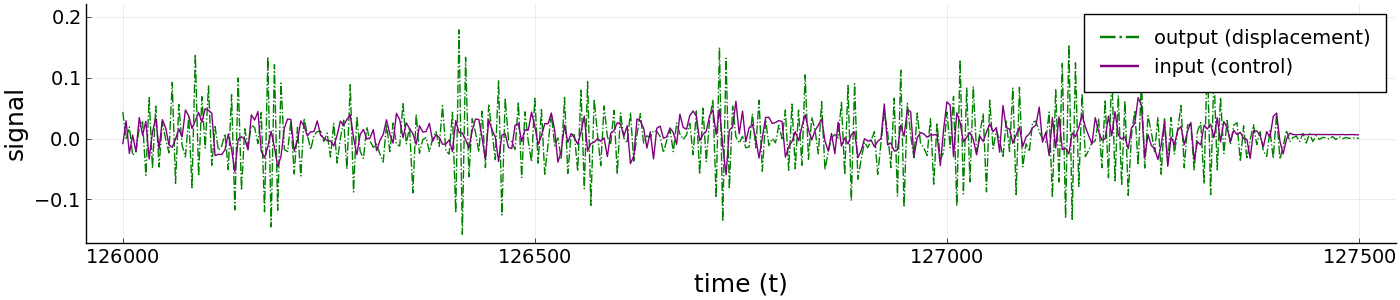

In [9]:
ss = 4
ix = 126000:ss:127500
p31 = Plots.plot(ix, output[ix], color="green", markersize=2, xlabel="time (t)", label="output (displacement)", linestyle=:dashdot)    
Plots.plot!(ix, input[ix], color="purple", markersize=2, xlabel="time (t)", label="input (control)", size=(1400,300), ylim=[-.16, .21], legend=:topright, tickfontsize=14, legendfontsize=14, ylabel="signal", guidefontsize=18)

In [11]:
Plots.savefig(p31, "figures/input-output_seq1.png")
Plots.savefig(p31, "figures/input-output_seq1.pdf")

## Solution steps

### 1. Discretize

I'm using a central difference for the second derivative and a forward difference for the first derivative. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The state transition can now be written as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + c (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$
Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
% (m + c) x_{t+1}&\ + (-2m - c + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
x_{t+1}&\ = \frac{2m + c - a}{m + c} x_{t} + \frac{-b}{m + c}x_t^3 + \frac{-m}{m + c} x_{t-1} + \frac{1}{m + c} u_t + \frac{1}{m + c} w_t \, .
\end{align}$$

### 2. Substitute variables and reduce order

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{e} g(z_{t-1}, \theta) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where

$$\begin{align}
\theta_1 = \frac{2m+c-a}{m+c} \ , \quad
\theta_2 = \frac{-b}{m+c} \ , \quad
\theta_3 = \frac{-m}{m+c} \ , \quad
\eta = \frac{1}{m+c} \ , \quad
\gamma^{-1} = \frac{\tau^{-1}}{(m+c)^2} \, ,
\end{align}$$

and $g(z_{t-1}, \theta) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,c,a,b,\tau$ and five equations. I can invert the mapping between $\phi = (m, c, a, b, \tau)$ and $\psi = (\theta_1, \theta_2, \theta_3, \eta, \gamma)$ to recover MAP estimates for the physical parameters. Variable substitution allows for more freedom in choosing priors.

The system is now a nonlinear autoregressive process:

$$z_t = f(z_{t-1}, \theta, \eta, u_t) + \tilde{w}_t$$

where $f(z_{t-1}, \theta, \eta, u_t) = Sz_{t-1} + e g(z_{t-1}, \theta) + e \eta u_t$. Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_t \sim&\ \mathcal{N}(f(z_{t-1}, \theta, \eta, u_t), V) \\
y_t \sim&\ \mathcal{N}(e^{\top} z_t, \xi^{-1}) \, ,
\end{align}$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W = V^{-1} = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### 4. Approximating the nonlinearity

The nonlinearity is approximated using a first-order Taylor expansion. The work here revolves around working out the expectations for $g(x,\theta)$:

$$ g(x,\theta) = g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and you could argue that you don't need to approximate it. However, the first-order Taylor is exact in that case.

### 5. Choose priors

We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. By examing the nonlinear transform $\psi = G(\phi)$, we realize that $\theta_1$, $\theta_2$, $\theta_3$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \ , \quad 
\eta \sim \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \ , \quad  
\gamma \sim \text{Gamma}(a^{0}_\gamma, b^{0}_\gamma) \, .
\end{align}$$

### 6. Choose recognition model

We do not introduce any independencies; the recognition model follows the generative model:

$$\begin{align}
q(\theta) \sim \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \ , \quad 
q(\eta) \sim \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \ , \quad  
q(\gamma) \sim \text{Gamma}(a^{0}_\gamma, b^{0}_\gamma) \, .
\end{align}$$

## Implementation

We implemented the above solution using [ForneyLab.jl](https://github.com/biaslab/ForneyLab.jl) and a custom node called "NLARX". It contains a Nonlinear Latent Autoregressive model with eXogenous input to model the state transition.

In [4]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using ProgressMeter

include("NLARX-node/NLARX.jl")
include("NLARX-node/util.jl")
using .NLARX

In [5]:
# System identification graph
graph1 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
g(θ, x) = θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(θ, z_tmin1, η, placeholder(:u_t), γ, g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8733464565357851642 -->
 
 8733464565357851642 
 
 placeholder_a_ξ 
 
<!-- 3916151582327764914 -->
 
 3916151582327764914 
 
 placeholder_w_η 
 
<!-- 14037139588679457589 -->
 
 14037139588679457589 
 
 𝒩 
 y_t 
 
<!-- 12573161510838581741 -->
 
 12573161510838581741 
 
 dot 
 dotproduct_1 
 
<!-- 14037139588679457589--12573161510838581741 -->
 
 14037139588679457589--12573161510838581741 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 7007407715506011965 -->
 
 7007407715506011965 
 
 Gam 
 gamma_2 
 
<!-- 14037139588679457589--7007407715506011965 -->
 
 14037139588679457589--7007407715506011965 
 
 ξ 
 1 out 
 3 w 
 
<!-- 10879339209517816528 -->
 
 10879339209517816528 
 
 NLARX 
 z_t 
 
<!-- 11791439870960117044 -->
 
 11791439870960117044 
 
 𝒩 
 z_tmin1 
 
<!-- 10879339209517816528--11791439870960117044 -->
 
 10879339209517816528--11791439870960117044 
 
 z_tmin1 
 1 out 
 2 x 
 
<!-- 18180065323575455011 -->
 
 18180065323575455011 
 
 Gam 
 gamma_1 
 
<!-- 10879339209517816528--18180065323575455011 -->
 
 10879339209517816528--18180065323575455011 
 
 γ 
 1 out 
 6 γ 
 
<!-- 2735100412182869982 -->
 
 2735100412182869982 
 
 placeholder_u_t 
 
<!-- 10879339209517816528--2735100412182869982 -->
 
 10879339209517816528--2735100412182869982 
 
 u_t 
 1 out 
 5 u 
 
<!-- 9433860530801908918 -->
 
 9433860530801908918 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 10879339209517816528--9433860530801908918 -->
 
 10879339209517816528--9433860530801908918 
 
 θ 
 1 out 
 3 θ 
 
<!-- 521528674840681427 -->
 
 521528674840681427 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 10879339209517816528--521528674840681427 -->
 
 10879339209517816528--521528674840681427 
 
 η 
 1 out 
 4 η 
 
<!-- 12573161510838581741--10879339209517816528 -->
 
 12573161510838581741--10879339209517816528 
 
 z_t 
 1 y 
 2 in1 
 
<!-- 7673832427799054885 -->
 
 7673832427799054885 
 
 clamp_1 
 
<!-- 12573161510838581741--7673832427799054885 -->
 
 12573161510838581741--7673832427799054885 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 10432832961930519106 -->
 
 10432832961930519106 
 
 placeholder_w_θ 
 
<!-- 7343769742192923710 -->
 
 7343769742192923710 
 
 placeholder_y_t 
 
<!-- 7343769742192923710--14037139588679457589 -->
 
 7343769742192923710--14037139588679457589 
 
 y_t 
 1 out 
 1 out 
 
<!-- 5179144414874139554 -->
 
 5179144414874139554 
 
 placeholder_m_z 
 
<!-- 12380021307492962804 -->
 
 12380021307492962804 
 
 placeholder_w_z 
 
<!-- 7007407715506011965--8733464565357851642 -->
 
 7007407715506011965--8733464565357851642 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 17684254788953120214 -->
 
 17684254788953120214 
 
 placeholder_b_ξ 
 
<!-- 7007407715506011965--17684254788953120214 -->
 
 7007407715506011965--17684254788953120214 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 14841821331756685937 -->
 
 14841821331756685937 
 
 placeholder_m_θ 
 
<!-- 11791439870960117044--5179144414874139554 -->
 
 11791439870960117044--5179144414874139554 
 
 m_z 
 1 out 
 2 m 
 
<!-- 11791439870960117044--12380021307492962804 -->
 
 11791439870960117044--12380021307492962804 
 
 w_z 
 1 out 
 3 w 
 
<!-- 2287788286901342906 -->
 
 2287788286901342906 
 
 placeholder_a_γ 
 
<!-- 12415202948020524304 -->
 
 12415202948020524304 
 
 placeholder_b_γ 
 
<!-- 18180065323575455011--2287788286901342906 -->
 
 18180065323575455011--2287788286901342906 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 18180065323575455011--12415202948020524304 -->
 
 18180065323575455011--12415202948020524304 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 9433860530801908918--10432832961930519106 -->
 
 9433860530801908918--10432832961930519106 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 9433860530801908918--14841821331756685937 -->
 
 9433860530801908918--14841821331756685937 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 11801780610974202505 -->
 

In [6]:
# Specify recognition model
q1 = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z_t, :z_tmin1, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)

# Compile inference algorithm
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code)

In [7]:
# Forecasting graph
graph2 = FactorGraph()

# State prior
@RV z_pred_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z_pred, dims=(2,)), placeholder(:w_z_pred, dims=(2, 2)), id=:z_pred_tmin1)

# Autoregressive node
@RV z_pred_t ~ NLatentAutoregressiveX(placeholder(:θ, dims=(3,)), z_pred_tmin1, placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:z_pred_t)

# Draw time-slice subgraph
ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(z_pred_t, z_pred_tmin1, ids=[:z_pred_t, :z_pred_tmin1])
algo2 = variationalAlgorithm(q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4856952443364498640 -->
 
 4856952443364498640 
 
 placeholder_w_z_pred 
 
<!-- 8448253069722030016 -->
 
 8448253069722030016 
 
 placeholder_η 
 
<!-- 6817190997184502931 -->
 
 6817190997184502931 
 
 NLARX 
 z_pred_t 
 
<!-- 6817190997184502931--8448253069722030016 -->
 
 6817190997184502931--8448253069722030016 
 
 η 
 1 out 
 4 η 
 
<!-- 10994252541584021099 -->
 
 10994252541584021099 
 
 placeholder_u_t 
 
<!-- 6817190997184502931--10994252541584021099 -->
 
 6817190997184502931--10994252541584021099 
 
 u_t 
 1 out 
 5 u 
 
<!-- 1697060767307059025 -->
 
 1697060767307059025 
 
 𝒩 
 z_pred_tmin1 
 
<!-- 6817190997184502931--1697060767307059025 -->
 
 6817190997184502931--1697060767307059025 
 
 z_pred_tmin1 
 1 out 
 2 x 
 
<!-- 4639274324504223427 -->
 
 4639274324504223427 
 
 placeholder_θ 
 
<!-- 6817190997184502931--4639274324504223427 -->
 
 6817190997184502931--4639274324504223427 
 
 θ 
 1 out 
 3 θ 
 
<!-- 2219952325378962339 -->
 
 2219952325378962339 
 
 placeholder_γ 
 
<!-- 6817190997184502931--2219952325378962339 -->
 
 6817190997184502931--2219952325378962339 
 
 γ 
 1 out 
 6 γ 
 
<!-- 874255346970547384 -->
 
 874255346970547384 
 
 placeholder_m_z_pred 
 
<!-- 1697060767307059025--4856952443364498640 -->
 
 1697060767307059025--4856952443364498640 
 
 w_z_pred 
 1 out 
 3 w 
 
<!-- 1697060767307059025--874255346970547384 -->
 
 1697060767307059025--874255346970547384 
 
 m_z_pred 
 1 out 
 2 m 
 
<!-- 95992815831887499012 -->
 
 95992815831887499012 
 
<!-- 95992815831887499012--6817190997184502931 -->
 
 95992815831887499012--6817190997184502931 
 
 z_pred_t 
 1 y

### Infer parameters and forecast ahead

In [13]:
# Number of steps ahead
TT = 1

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (zeros(2,T - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T - TT)))
params_θ = (ones(3,T - TT), repeat(.1 .*float(eye(3)), outer=(1,1,T - TT)))
params_η = (ones(1,T - TT), .1*ones(1,T - TT))
params_γ = (1e3*ones(1,T - TT), 1e1*ones(1,T - TT))
params_ξ = (1e8*ones(1,T - TT), 1e3*ones(1,T - TT))

# Initialize future state arrays
params_preds = (zeros(2, T - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T - TT, TT+1)))

# Start progress bar
p = Progress(T - TT, 1, "At time ")

for t = 2:(T - TT)
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t-1], w=params_θ[2][:,:,t-1])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t-1], w=params_η[2][1,t-1])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t-1], b=params_γ[2][1,t-1])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t-1], b=params_ξ[2][1,t-1])
    
    # Clamp parameters
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_z[1][:,t-1],
                :w_z => params_z[2][:,:,t-1],
                :m_θ => params_θ[1][:,t-1],
                :w_θ => params_θ[2][:,:,t-1],
                :m_η => params_η[1][1,t-1],
                :w_η => params_η[2][1,t-1],
                :a_γ => params_γ[1][1,t-1],
                :b_γ => params_γ[2][1,t-1],
                :a_ξ => params_ξ[1][1,t-1],
                :b_ξ => params_ξ[2][1,t-1])

    # Iterate recognition model updates
    for i = 1:num_iterations

        # Update parameters
        stepη!(data, marginals)
        stepθ!(data, marginals)
        
        # Update states
        stepz_tmin1!(data, marginals)
        stepz_t!(data, marginals)
        
        # Update noises
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    
    end

    # Store current parameterizations of marginals
    params_z[1][:,t] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t] = marginals[:z_t].params[:w]
    params_θ[1][:,t] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t] = marginals[:θ].params[:w]
    params_η[1][1,t] = unsafeMean(marginals[:η])
    params_η[2][1,t] = marginals[:η].params[:w]
    params_γ[1][1,t] = marginals[:γ].params[:a]
    params_γ[2][1,t] = marginals[:γ].params[:b]
    params_ξ[1][1,t] = marginals[:ξ].params[:a]
    params_ξ[2][1,t] = marginals[:ξ].params[:b]
    
    "Predict future state"
    
    if T > 2
    
        params_preds[1][:,t,1] = params_z[1][:,t]
        params_preds[2][:,:,t,1] = params_z[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:z_pred_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,t,tt], w=params_preds[2][:,:,t,tt])
            marginals[:z_pred_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,t,tt], w=params_preds[2][:,:,t,tt])

            data = Dict(:u_t => input[t+tt],
                        :m_z_pred => params_preds[1][:,t,tt],
                        :w_z_pred => params_preds[2][:,:,t,tt],
                        :θ => params_θ[1][:,t],
                        :η => params_η[1][t],
                        :γ => params_γ[1][t]/params_γ[2][t])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepz_pred_t!(data, marginals)
                stepz_pred_tmin1!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_preds[1][:,t,tt+1] = unsafeMean(marginals[:z_pred_t])
            params_preds[2][:,:,t,tt+1] = marginals[:z_pred_t].params[:w]

        end
    end
end

At time 100%|███████████████████████████████████████████| Time: 0:06:20:08


In [ ]:
# Store predictions for later comparisons
results = Dict{String, Array}()
results["NLARX-mean"] = params_preds[1]
results["NLARX-prec"] = params_preds[2];

### Visualize results

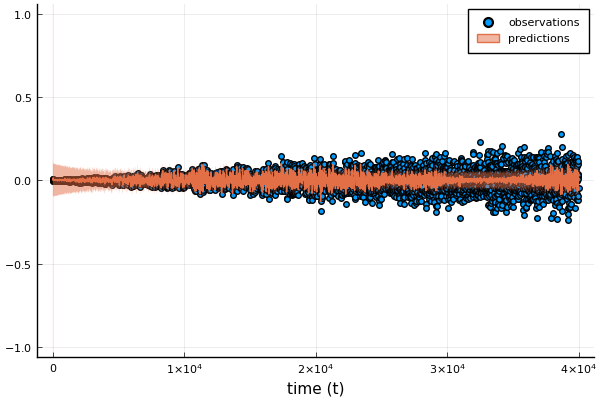

In [19]:
# Mean and std dev of predictions
predictions_mean = params_preds[1][1,:,TT+1]
predictions_std = sqrt.(inv.(params_preds[2][1,1,:,TT+1])) 

# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Plot predictions
scatter(viz_ix, output[viz_ix], label="observations", xlabel="time (t)", ylims=[-1., 1.])
plot!(viz_ix, predictions_mean[viz_ix], ribbon=[predictions_std[viz_ix], predictions_std[viz_ix]], label="predictions")

In [ ]:
Plots.savefig(p23, "figures/predictions_nlarx.png")

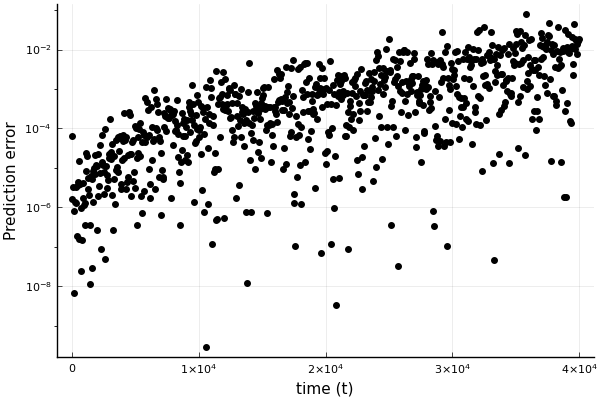

In [31]:
# Compute prediction error
pred_error = (predictions_mean[2:end] .- output[3:end]).^2

# Subsample for visualization
ss = 50
viz_ix = 1:ss:40000

# Scatter error over time
scatter(viz_ix, pred_error[viz_ix], color="black", xlabel="time (t)", ylabel="Prediction error", label="", yscale=:log10)

In [15]:
Plots.savefig(p23, "figures/pred-error_nlarx.png")

## Baseline: linear autoregression

In [32]:
# System identification graph
graph3 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Autoregression function
g(θ, x) = θ[1]*x[1] + θ[2]*x[2]

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(θ, z_tmin1, η, placeholder(:u_t), γ, g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Inference algorithm
q1 = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z_t, :z_tmin1, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));

# Forecasting graph
graph4 = FactorGraph()

# State prior
@RV z_pred_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_pred_t ~ NLatentAutoregressiveX(placeholder(:θ, dims=(2,)), z_pred_tmin1, placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:z_t)

# Inference algorithm
q4 = PosteriorFactorization(z_pred_t, z_pred_tmin1, ids=[:z_pred_t, :z_pred_tmin1])
algo4 = variationalAlgorithm(q4, free_energy=false)
source_code4 = algorithmSourceCode(algo4, free_energy=false)
eval(Meta.parse(source_code4));

In [17]:
# Number of steps ahead
TT = 1

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (zeros(2,T - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T - TT)))
params_θ = (ones(2,T - TT), repeat(.1 .*float(eye(2)), outer=(1,1,T - TT)))
params_η = (ones(1,T - TT), .1*ones(1,T - TT))
params_γ = (1e3*ones(1,T - TT), 1e1*ones(1,T - TT))
params_ξ = (1e8*ones(1,T - TT), 1e3*ones(1,T - TT))

# Initialize future state arrays
params_preds = (zeros(2, T - TT, TT+1), repeat(.1 .*float(eye(2)), outer=(1,1,T - TT, TT+1)))

# Start progress bar
p = Progress(T - TT, 1, "At time ")

for t = 2:(T - TT)
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t-1], w=params_z[2][:,:,t-1])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t-1], w=params_θ[2][:,:,t-1])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t-1], w=params_η[2][1,t-1])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t-1], b=params_γ[2][1,t-1])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t-1], b=params_ξ[2][1,t-1])
    
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_z[1][:,t-1],
                :w_z => params_z[2][:,:,t-1],
                :m_θ => params_θ[1][:,t-1],
                :w_θ => params_θ[2][:,:,t-1],
                :m_η => params_η[1][1,t-1],
                :w_η => params_η[2][1,t-1],
                :a_γ => params_γ[1][1,t-1],
                :b_γ => params_γ[2][1,t-1],
                :a_ξ => params_ξ[1][1,t-1],
                :b_ξ => params_ξ[2][1,t-1])

    # Iterate recognition model updates
    for i = 1:num_iterations

        # Update parameters
        stepη!(data, marginals)
        stepθ!(data, marginals)
        
        # Update states
        stepz_tmin1!(data, marginals)
        stepz_t!(data, marginals)
        
        # Update noises
        stepγ!(data, marginals)
        stepξ!(data, marginals)
    
    end

    # Store current parameterizations of marginals
    params_z[1][:,t] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t] = marginals[:z_t].params[:w]
    params_θ[1][:,t] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t] = marginals[:θ].params[:w]
    params_η[1][1,t] = unsafeMean(marginals[:η])
    params_η[2][1,t] = marginals[:η].params[:w]
    params_γ[1][1,t] = marginals[:γ].params[:a]
    params_γ[2][1,t] = marginals[:γ].params[:b]
    params_ξ[1][1,t] = marginals[:ξ].params[:a]
    params_ξ[2][1,t] = marginals[:ξ].params[:b]
    
    "Forecast several steps ahead"
    
    if T > 2
    
        params_preds[1][:,t,1] = params_z[1][:,t]
        params_preds[2][:,:,t,1] = params_z[2][:,:,t]

        for tt = 1:TT

            # Initialize marginals
            marginals[:z_pred_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,t,tt], w=params_preds[2][:,:,t,tt])
            marginals[:z_pred_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,t,tt], w=params_preds[2][:,:,t,tt])

            data = Dict(:u_t => input[t+tt],
                        :m_z => params_preds[1][:,t,tt],
                        :w_z => params_preds[2][:,:,t,tt],
                        :θ => params_θ[1][:,t],
                        :η => params_η[1][t],
                        :γ => params_γ[1][t]/params_γ[2][t])

            # Iterate variational parameter updates
            for i = 1:num_iterations
                stepz_pred_t!(data, marginals)
                stepz_pred_tmin1!(data, marginals)
            end

            # Store current parameterizations of marginals
            params_preds[1][:,t,tt+1] = unsafeMean(marginals[:z_pred_t])
            params_preds[2][:,:,t,tt+1] = marginals[:z_pred_t].params[:w]

        end
    end
end

At time 100%|███████████████████████████████████████████| Time: 0:04:21


In [33]:
# Store predictions for later comparisons
results = Dict{String, Array}()
results["LARX-mean"] = params_preds[1]
results["LARX-prec"] = params_preds[2];

### Visualize results

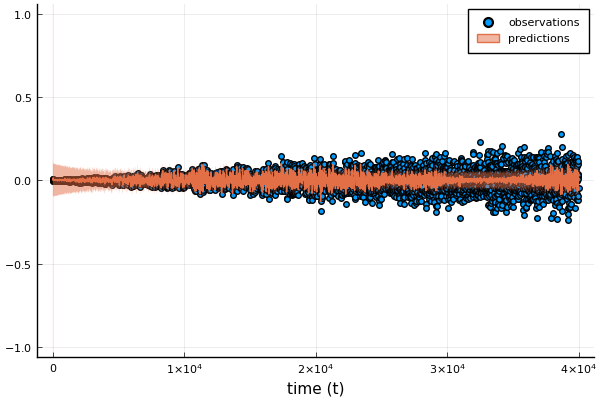

In [34]:
# Mean and std dev of predictions
predictions_mean = params_preds[1][1,:,TT+1]
predictions_std = sqrt.(inv.(params_preds[2][1,1,:,TT+1])) 

# Subsample for visualization
ss = 10
viz_ix = 1:ss:40000

# Plot predictions
p302 = scatter(viz_ix, output[viz_ix], label="observations", xlabel="time (t)", ylims=[-1., 1.])
plot!(viz_ix, predictions_mean[viz_ix], ribbon=[predictions_std[viz_ix], predictions_std[viz_ix]], label="predictions")

In [ ]:
Plots.savefig(p302, "figures/predictions_larx.png")

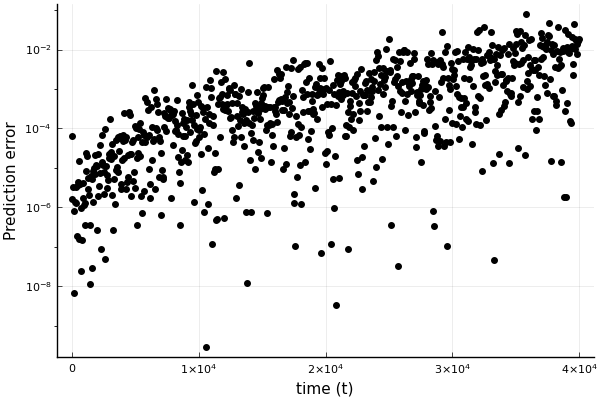

In [35]:
# Compute prediction error
pred_error = (predictions_mean[2:end] .- output[3:end]).^2

# Subsample for visualization
ss = 50
viz_ix = 1:ss:40000

# Scatter error over time
p303 = scatter(viz_ix, pred_error[viz_ix], color="black", xlabel="time (t)", ylabel="Prediction error", label="", yscale=:log10)

In [20]:
Plots.savefig(p303, "figures/pred-error_larx.png")

## Compare nonlinear to linear

In [38]:
# Compute MSE for each step ahead
MSE_LARX = mean((results["LARX-mean"][1,:,TT+1] .- output[2:end]).^2)
MSE_NLARX = mean((results["NLARX-mean"][1,:,TT+1] .- output[2:end]).^2)

println("MSE LARX = "*string(MSE_LARX))
println("MSE NLARX = "*string(MSE_NLARX))

KeyError: KeyError: key "NLARX-mean" not found

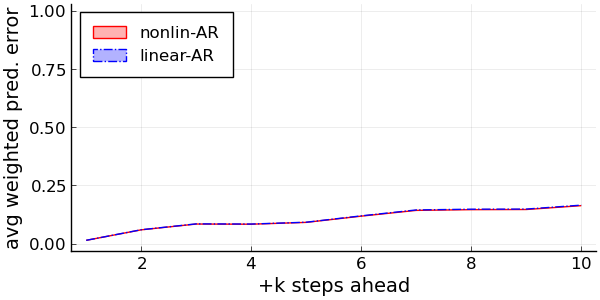

In [38]:
ix = 10:87390

mpwerr_lar = mean(pred_pwerr_lar[ix,:], dims=1)' 
spwerr_lar = sqrt.(var(pred_pwerr_lar[ix,:], dims=1)') ./length(ix)
mpwerr_nar = mean(pred_pwerr_nar[ix,:], dims=1)' 
spwerr_nar = sqrt.(var(pred_pwerr_nar[ix,:], dims=1)') ./ length(ix)

# p110 = plot(1:TT, mpwerr_nar, color="red", label="nonlin-AR")
p110 = plot(1:TT, mpwerr_nar, ribbon=[spwerr_nar, spwerr_nar], fillalpha=0.3, color="red", label="nonlin-AR")
# plot!(1:TT, mpwerr_lar, color="blue", label="linear-AR", linestyle=:dashdot)
plot!(1:TT, mpwerr_lar, ribbon=[spwerr_lar, spwerr_lar], fillalpha=0.3, label="linear-AR", linestyle=:dashdot, color="blue", size=(600,300), ylim=[0., 1.], legend=:topleft, tickfontsize=12, xlabel="+k steps ahead", ylabel="avg weighted pred. error", legendfontsize=12, guidefontsize=14)
# plot!(1:TT, mpwerr_rw, color="green", label="RW", size=(600,400), ylim=[0., 1.], legend=:topleft)

In [39]:
savefig(p110, "viz/mpwerr_comparison.png")
savefig(p110, "viz/mpwerr_comparison.pdf")

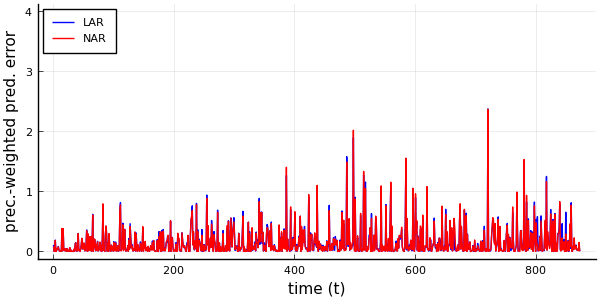

In [40]:
# Select subsampling
ss = 100

# Select a number of time-steps ahead
tt = 10

# Index performance metrics
pwerr_rw_tt = pred_pwerr_rw[10:ss:end,tt]
pwerr_lar_tt = pred_pwerr_lar[10:ss:end,tt]
pwerr_nar_tt = pred_pwerr_nar[10:ss:end,tt]

# Plot mean difference for all time
# plot(pwerr_rw_tt, color="green", label="RW", markersize=2, size=(600,400), xlabel="time (t)", ylabel="precision-weighted prediction error")
plot(pwerr_lar_tt, color="blue", label="LAR", markersize=2, size=(600,300), xlabel="time (t)", ylabel="prec.-weighted pred. error")
plot!(pwerr_nar_tt, color="red", label="NAR", markersize=2, size=(600,300), ylim=[0., 4.], legend=:topleft)

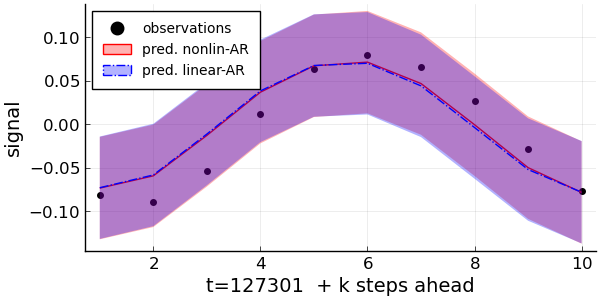

In [41]:
# Pick a time-point and visualize forecasting
t = 87200

xticks = [string(t)*"+1", string(t)*"+2"]

# Mean and std dev of predictions
zpred_nar_mean = params_zpred_nar[1][1,t,2:TT+1]
zpred_nar_std = sqrt.(inv.(params_zpred_nar[2][1,1,t,2:TT+1])) 
zpred_lar_mean = params_preds[1][1,t,2:TT+1]
zpred_lar_std = sqrt.(inv.(params_preds[2][1,1,t,2:TT+1])) 


p224 = scatter(output_[t+1:t+TT], label="observations", color="black", xlabel="t="*string(t+40101)*"  + k steps ahead")
plot!(zpred_nar_mean, ribbon=[zpred_nar_std, zpred_nar_std], fillalpha=0.3, color="red", label="pred. nonlin-AR")
plot!(zpred_lar_mean, ribbon=[zpred_lar_std, zpred_lar_std], fillalpha=0.3, color="blue", linestyle=:dashdot, label="pred. linear-AR", size=(600,300), tickfontsize=12, legendfontsize=10, legend=:topleft, ylabel="signal", guidefontsize=14)

In [42]:
savefig(p224, "viz/example-forecast-comparison.png")
savefig(p224, "viz/example-forecast-comparison.pdf")